# Setup

In [2]:
import numpy as np
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import os
import time
import uuid
import cv2
import shutil
import albumentations as A

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Image Pipeline

In [4]:
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'))

Metal device set to: Apple M1 Pro


2022-09-09 01:49:46.931553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 01:49:46.931994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
images.as_numpy_iterator().next()

2022-09-09 01:49:47.795382: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


b'data/images/47827604-2f9d-11ed-82be-8e6ce523a1a8.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

2022-09-09 01:49:49.371283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[143, 123,  98],
        [143, 123,  98],
        [144, 124,  99],
        ...,
        [ 78,  82,  55],
        [ 75,  80,  50],
        [ 73,  78,  48]],

       [[147, 127, 102],
        [146, 126, 101],
        [147, 127, 102],
        ...,
        [ 80,  84,  57],
        [ 76,  81,  51],
        [ 73,  78,  48]],

       [[151, 131, 107],
        [150, 130, 106],
        [149, 129, 105],
        ...,
        [ 82,  86,  59],
        [ 78,  83,  53],
        [ 75,  80,  50]],

       ...,

       [[ 87,  86,  81],
        [ 85,  84,  79],
        [ 84,  83,  78],
        ...,
        [ 92,  96,  73],
        [ 93,  97,  74],
        [ 93,  97,  74]],

       [[ 87,  86,  82],
        [ 85,  84,  80],
        [ 84,  83,  79],
        ...,
        [ 90,  95,  72],
        [ 90,  96,  70],
        [ 89,  95,  69]],

       [[ 86,  85,  81],
        [ 85,  84,  80],
        [ 84,  83,  79],
        ...,
        [ 90,  95,  72],
        [ 89,  95,  69],
        [ 88,  94,  68]]

## Plot Raw Image

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

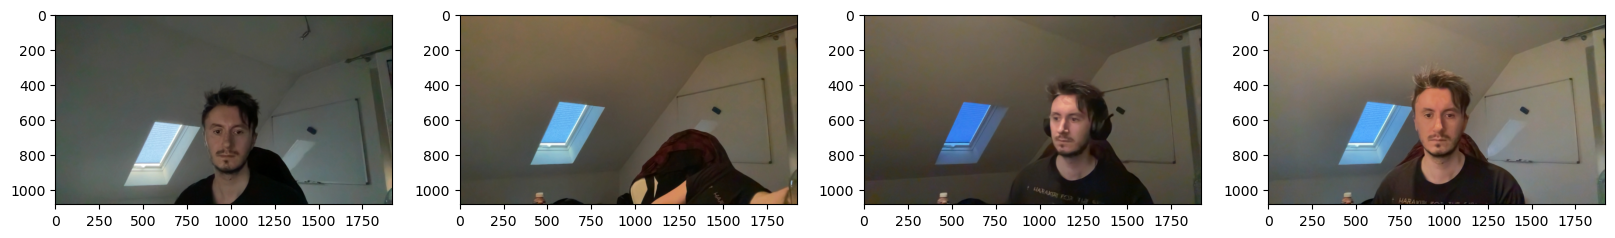

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(image_generator.next()):
    ax[idx].imshow(image) 
plt.show()

## Split into Training/Validation/Test Sets

Split into 0.7 / 0.15 / 0.15 (Train / Val / Test)

In [19]:
root_dir = 'data'
image_src = 'data/images'
label_src = 'data/labels'

for dir_name in ['train', 'val', 'test']:
    os.makedirs(root_dir +'/'+dir_name)
    os.makedirs(root_dir +'/'+dir_name+'/images')
    os.makedirs(root_dir +'/'+dir_name+'/labels')

In [20]:
allFileNames = os.listdir(image_src)
allFileNames = [name.split('.jpg')[0] for name in allFileNames]
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])

In [21]:
file_dict = {k:{} for k in ['train', 'val', 'test']}

In [22]:
file_dict

{'train': {}, 'val': {}, 'test': {}}

In [23]:
file_dict['train']['images'] = [image_src +'/'+ name + '.jpg' for name in train_FileNames.tolist()]
file_dict['val']['images'] = [image_src +'/' + name + '.jpg' for name in val_FileNames.tolist()]
file_dict['test']['images'] = [image_src +'/' + name + '.jpg' for name in test_FileNames.tolist()]

file_dict['train']['labels'] = [label_src+'/'+ name + '.json' for name  in train_FileNames.tolist()]
file_dict['val']['labels'] = [label_src+'/' + name + '.json' for name  in val_FileNames.tolist()]
file_dict['test']['labels'] = [label_src+'/' + name + '.json' for name  in test_FileNames.tolist()]

In [24]:
for dir_name in ['train', 'val', 'test']:
    for image_name, label_name in zip(file_dict[dir_name]['images'], file_dict[dir_name]['labels']):
        shutil.copy(image_name, f'Data/{dir_name}/images')
        try:
            shutil.copy(label_name, f'Data/{dir_name}/labels')
        except:
            # image does not contain a face
            pass

## Augmentation Pipeline

In [17]:
# Create Directory Structure for augmented data

In [25]:
root_dir = 'aug_data'
os.makedirs(root_dir)
for dir_name in ['train', 'val', 'test']:
    os.makedirs(root_dir +'/'+dir_name)
    os.makedirs(root_dir +'/'+dir_name+'/images')
    os.makedirs(root_dir +'/'+dir_name+'/labels')

In [26]:
transform = A.Compose([A.RandomCrop(width=450, height=450), 
                       A.HorizontalFlip(p=0.5), 
                       A.RandomBrightnessContrast(p=0.2),
                       A.RandomGamma(p=0.2), 
                       A.RGBShift(p=0.2), 
                       A.VerticalFlip(p=0.5)], 
                      bbox_params=A.BboxParams(format='albumentations', 
                                               label_fields=['class_labels']))

In [32]:
img = cv2.imread(os.path.join('data','train', 'images','0b02cc3c-2f9e-11ed-b077-8e6ce523a1a8.jpg'))
with open(os.path.join('data', 'train', 'labels', '0b02cc3c-2f9e-11ed-b077-8e6ce523a1a8.json'), 'r') as f:
    label = json.load(f)
    
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
h, w, _ = img.shape
coords = list(np.divide(coords, [w,h,w,h]))

coords

[0.29507575757575755,
 0.3669191919191919,
 0.5057765151515151,
 0.7688552188552188]

In [33]:
augmented = transform(image=img, bboxes=[coords], class_labels=['face'])

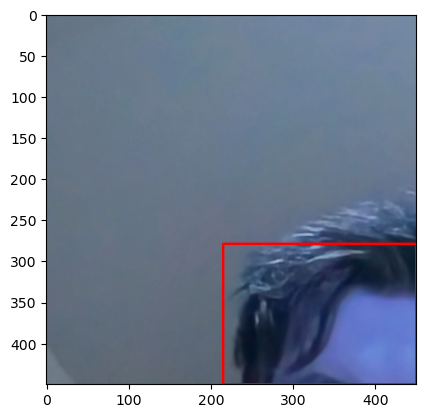

In [34]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [35]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            h, w, _ = img.shape
            coords = list(np.divide(coords, [w,h,w,h]))

        try: 
            for x in range(60):
                augmented = transform(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.7460700757575758, 0.4595117845117845, 0.5815340909090909, 0.8888047138047139, 'face'].
x_max is less than or equal to x_min for bbox [0.6336174242424242, 0.16700336700336701, 0.4465909090909091, 0.587878787878788, 'face'].
x_max is less than or equal to x_min for bbox [0.5981060606060605, 0.41531986531986526, 0.37556818181818186, 0.893013468013468, 'face'].
x_max is less than or equal to x_min for bbox [0.5898200757575758, 0.7478114478114479, 0.40516098484848484, 0.3563973063973064, 'face'].
x_max is less than or equal to x_min for bbox [0.5495738636363636, 0.3353535353535353, 0.36728219696969694, 0.8488215488215488, 'face'].
x_max is less than or equal to x_min for bbox [0.6987215909090909, 0.43005050505050507, 0.5152462121212121, 0.8151515151515151, 'face'].
x_max is less than or equal to x_min for bbox [0.7330492424242424, 0.3563973063973064, 0.5365530303030304, 0.7730639730639731, 'face'].
x_max is less than or equal to x_min for bbo

## Load Augmented Images into TensorFlow Dataset

In [36]:
image_data = []
for dir_name in ['train', 'val', 'test']:
    path = os.path.join('aug_data', dir_name, 'images', '*.jpg')
    temp = tf.data.Dataset.list_files(path, shuffle=False)
    temp = temp.map(load_image)
    temp = temp.map(lambda x: tf.image.resize(x, (120,120)))
    temp = temp.map(lambda x: x/255)
    
    image_data.append(temp)

In [37]:
train_images, val_images, test_images = image_data

# Prepare Labels

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [39]:
label_data = []
for dir_name in ['train', 'val', 'test']:
    path = os.path.join('aug_data', dir_name, 'labels', '*.json')
    temp = tf.data.Dataset.list_files(path, shuffle=False)
    temp = temp.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    
    label_data.append(temp)

In [40]:
train_labels, val_labels, test_labels = label_data

In [41]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2760, 2760, 300, 300, 540, 540)

# Combine Label and Image Samples

In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


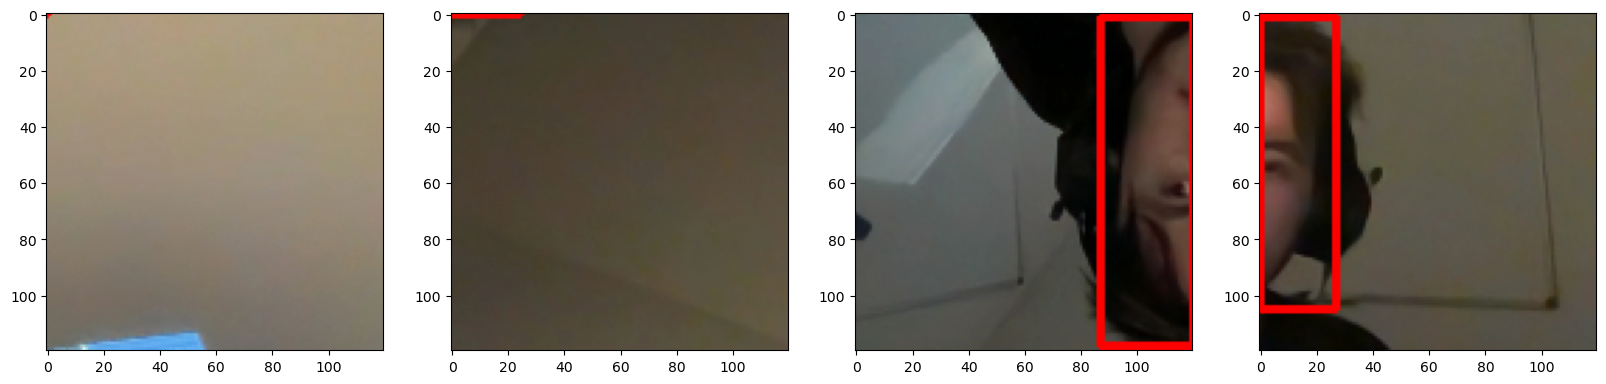

In [48]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning Model

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [50]:
vgg = VGG16(include_top=False)

In [51]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [52]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [53]:
facetracker = build_model()

In [54]:
X, y = train.as_numpy_iterator().next()

In [55]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 0s 161ms/step


2022-09-09 01:56:10.227980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(array([[0.50555325],
        [0.6176489 ],
        [0.5074926 ],
        [0.48596004],
        [0.5889123 ],
        [0.67076796],
        [0.71889454],
        [0.71379495]], dtype=float32),
 array([[0.5522615 , 0.5284033 , 0.4202528 , 0.6391072 ],
        [0.5800139 , 0.51496184, 0.4490155 , 0.68456393],
        [0.5681188 , 0.5303619 , 0.39593714, 0.633712  ],
        [0.5460809 , 0.53473556, 0.4111492 , 0.6407199 ],
        [0.59858465, 0.5231945 , 0.38051116, 0.624405  ],
        [0.5492996 , 0.53747547, 0.3899874 , 0.6432281 ],
        [0.58974767, 0.532616  , 0.36244726, 0.65411216],
        [0.5708467 , 0.5279535 , 0.41211277, 0.6348942 ]], dtype=float32))

# Optimizer and Loss Functions

In [56]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [57]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [58]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [59]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.726194>

In [60]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.882206>

In [61]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.726194>

In [62]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [63]:
model = FaceTracker(facetracker)

In [64]:
model.compile(opt, classloss, regressloss)

In [65]:
logdir='logs'

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [67]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-09-09 01:56:30.778658: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_10'
2022-09-09 01:56:30.781360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - ETA: 0s - total_loss: 0.8691 - class_loss: 0.2304 - regress_loss: 0.7539

2022-09-09 01:57:10.940301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 43s 105ms/step - total_loss: 0.8681 - class_loss: 0.2315 - regress_loss: 0.7523 - val_total_loss: 0.1574 - val_class_loss: 0.0144 - val_regress_loss: 0.1502
Epoch 2/10
345/345 [==============================] - 39s 104ms/step - total_loss: 0.3757 - class_loss: 0.1206 - regress_loss: 0.3154 - val_total_loss: 0.2829 - val_class_loss: 0.2249 - val_regress_loss: 0.1704
Epoch 3/10
345/345 [==============================] - 39s 104ms/step - total_loss: 0.2609 - class_loss: 0.0897 - regress_loss: 0.2161 - val_total_loss: 1.0609 - val_class_loss: 1.0678 - val_regress_loss: 0.5270
Epoch 4/10
345/345 [==============================] - 39s 104ms/step - total_loss: 0.2218 - class_loss: 0.0804 - regress_loss: 0.1816 - val_total_loss: 0.0173 - val_class_loss: 0.0095 - val_regress_loss: 0.0126
Epoch 5/10
345/345 [==============================] - 40s 105ms/step - total_loss: 0.1586 - class_loss: 0.0646 - regress_loss: 0.1263 - val_total_loss: 0.0257 - val_cl

In [69]:
hist.history

{'total_loss': [0.5122979283332825,
  0.07047466933727264,
  0.01551500428467989,
  0.08873631060123444,
  0.31108370423316956,
  0.002809097757562995,
  0.0037888474762439728,
  0.06006218492984772,
  0.09547515213489532,
  0.010230792686343193],
 'class_loss': [0.591830313205719,
  0.00883490964770317,
  0.013905340805649757,
  0.015914147719740868,
  0.0890238881111145,
  0.0037506495136767626,
  0.005257338285446167,
  0.0009859878337010741,
  0.01873655803501606,
  0.003775541903451085],
 'regress_loss': [0.21638278663158417,
  0.06605721265077591,
  0.008562333881855011,
  0.08077923953533173,
  0.2665717601776123,
  0.0009337730007246137,
  0.0011601782171055675,
  0.05956919118762016,
  0.08610687404870987,
  0.008343021385371685],
 'val_total_loss': [0.15741877257823944,
  0.28285840153694153,
  1.0609147548675537,
  0.01730576902627945,
  0.02573283016681671,
  0.4287465810775757,
  0.5243650078773499,
  0.06896477192640305,
  0.08677992969751358,
  0.14129915833473206],
 'va

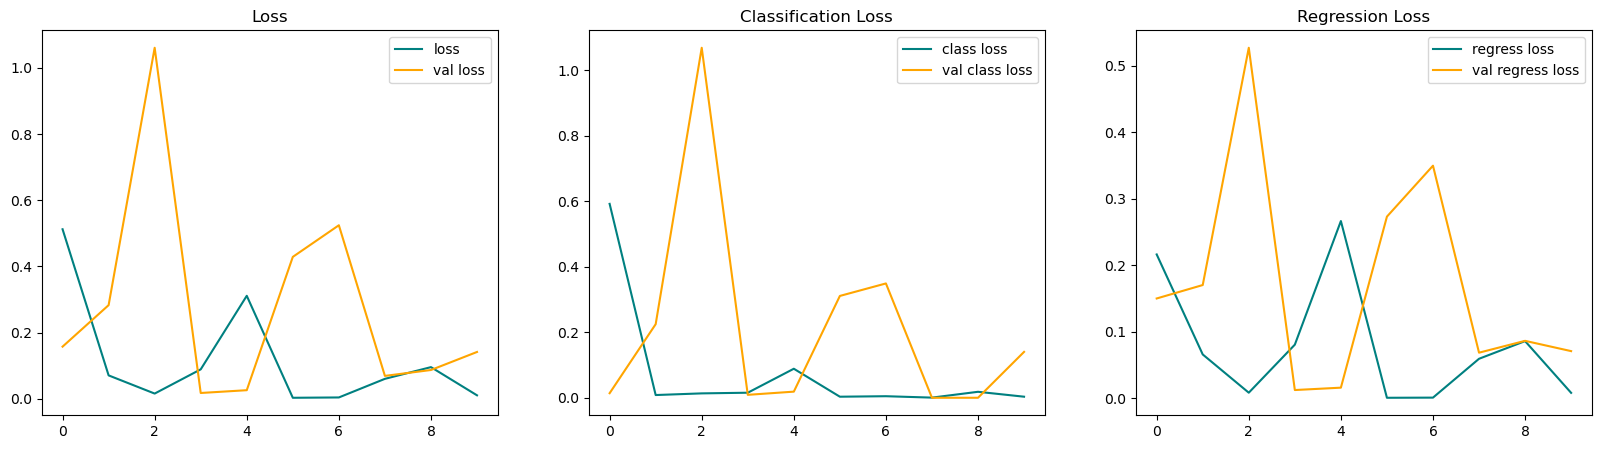

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [74]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [75]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


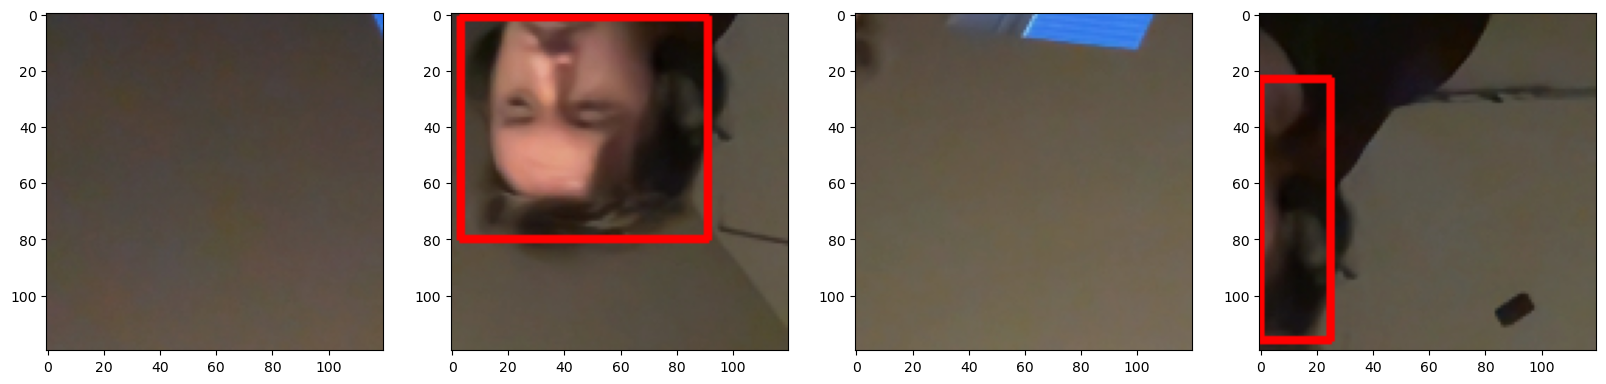

In [76]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Save Model

In [6]:
from tensorflow.keras.models import load_model

In [79]:
facetracker.save('facetracker.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.